In [ ]:
! pip install lime
! pip install interpret
! pip install eli5
! pip install shap

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import IPython
import eli5
from eli5 import show_prediction
import shap
import lime.lime_tabular
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
credito = pd.read_csv('Credit.csv')

In [4]:
credito.shape

(1000, 21)

In [5]:
credito.head()

checking_status  duration                    credit_history  \
0              <0         6  'critical/other existing credit'   
1        0<=X<200        48                   'existing paid'   
2   'no checking'        12  'critical/other existing credit'   
3              <0        42                   'existing paid'   
4              <0        24              'delayed previously'   

               purpose  credit_amount      savings_status employment  \
0             radio/tv           1169  'no known savings'        >=7   
1             radio/tv           5951                <100     1<=X<4   
2            education           2096                <100     4<=X<7   
3  furniture/equipment           7882                <100     4<=X<7   
4            'new car'           4870                <100     1<=X<4   

   installment_commitment       personal_status other_parties  ...  \
0                       4         'male single'          none  ...   
1                       2  'female div/dep/mar'          none  ...   
2                       2         'male single'          none  ...   
3                       2         'male single'     guarantor  ...   
4                       3         'male single'          none  ...   

    property_magnitude age  other_payment_plans     housing existing_credits  \
0        'real estate'  67                 none         own                2   
1        'real estate'  22                 none         own                1   
2        'real estate'  49                 none         own                1   
3     'life insurance'  45                 none  'for free'                1   
4  'no known property'  53                 none  'for free'                2   

                    job num_dependents  own_telephone foreign_worker class  
0               skilled              1            yes            yes  good  
1               skilled              1           none            yes   bad  
2  'unskilled resident'              2           none            yes  good  
3               skilled              2           none            yes  good  
4               skilled              2           none            yes   bad  

[5 rows x 21 columns]

In [6]:
previsores = credito.iloc[:,:-1].values
classe = credito.iloc[:,-1].values

In [7]:
labelencoder = LabelEncoder()
for i in range(previsores.shape[1]):
  if previsores[:,i].dtype == 'object':
    previsores[:,i] = labelencoder.fit_transform(previsores[:,i])

In [8]:
classe = labelencoder.fit_transform(classe)

In [9]:
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(previsores, classe, test_size=0.3)

In [10]:
modelo = RandomForestClassifier(n_estimators=1000)
modelo.fit(X_treinamento, y_treinamento)

RandomForestClassifier(n_estimators=1000)

#Lime

In [17]:
expl = lime.lime_tabular.LimeTabularExplainer(X_treinamento, feature_names=list(credito)[0:20],class_names='class')
prever = lambda x: modelo.predict_proba(x).astype(float)

exp = expl.explain_instance(X_teste[0], prever, num_features=5)
exp.show_in_notebook(show_all=True)

In [12]:
y_teste[0]

1

#Eli5

In [13]:
eli5.show_weights(modelo, feature_names = list(credito)[0:20])

In [14]:
previsores[1]

array([1, 29, 3, 7, 770, 3, 0, 1, 0, 2, 1, 2, 3, 1, 1, 0, 3, 0, 0, 1],
      dtype=object)

In [15]:
eli5.show_prediction(modelo, previsores[0], feature_names = list(credito)[0:20], show_feature_values=True)

#Shap


100%|===================| 597/600 [02:02<00:00]       

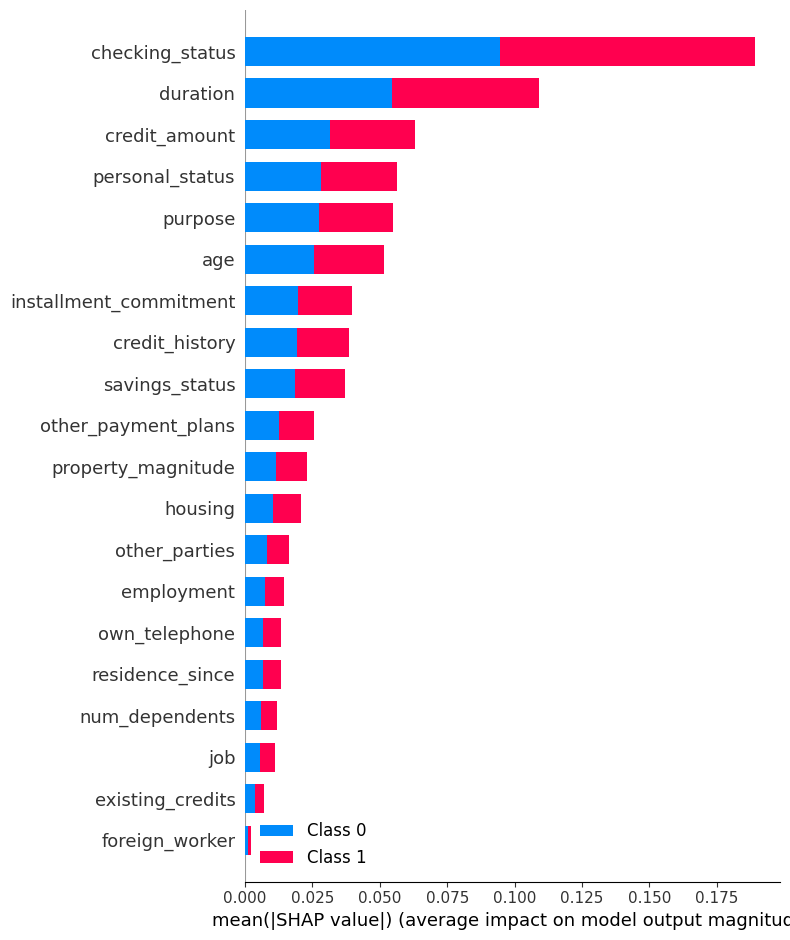

In [18]:
X_treinamento2 = X_treinamento.astype(float)
explainer = shap.Explainer(modelo, X_treinamento2)
shap_values = explainer.shap_values(X_teste)
shap.summary_plot(shap_values, X_teste, feature_names=list(credito)[0:20], plot_type='bar')
shap.force_plot(explainer.expected_value[1], shap_values[1])
shap.initjs()

#Interpret

In [19]:
set_visualize_provider(InlineProvider())
ebm = ExplainableBoostingClassifier(feature_names=list(credito)[0:20])
ebm.fit(X_treinamento, y_treinamento)
global_explanation = ebm.explain_global()
show(global_explanation)